# Figure 12: NH Sea Ice Extent (SIE) Skill 
- SIE == total area of grid cells where ice fraction exceeds 0.15

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

# SMYLE Utility functions
from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

## Create Dask Cluster

In [ ]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(20) #adapt(minimum_jobs=0, maximum_jobs=24)

In [4]:
cluster

# Data Intake:

In [6]:
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time','TLAT','TLON','tarea']].drop(['ULAT','ULON'])
    d0 = d0.chunk({'L':-1})
    return d0

In [7]:
%%time
# SMYLE-Nov IFRAC data
field = 'aice'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle11.nbytes/1e9 #GB

CPU times: user 20 s, sys: 9.61 s, total: 29.6 s
Wall time: 1min 5s


11.562035112

In [8]:
%%time
smyle11_seas = cal.mon_to_seas_dask2(smyle11).persist()

CPU times: user 9.1 s, sys: 155 ms, total: 9.25 s
Wall time: 9.7 s


In [9]:
%%time
# SMYLE-Feb IFRAC data
field = 'aice'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunks={'z_t':1,'nlat':80}
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02.nbytes/1e9 #GB

CPU times: user 40 s, sys: 9.96 s, total: 50 s
Wall time: 1min 22s


11.562035112

In [10]:
%%time
smyle02_seas = cal.mon_to_seas_dask2(smyle02).persist()

CPU times: user 10.1 s, sys: 102 ms, total: 10.2 s
Wall time: 10.7 s


In [11]:
%%time
# SMYLE-May IFRAC data
field = 'aice'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
#chunks={'z_t':1,'nlat':80}
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 46.5 s, sys: 10.2 s, total: 56.8 s
Wall time: 1min 20s


11.562035112

In [12]:
%%time
smyle05_seas = cal.mon_to_seas_dask2(smyle05).persist()

CPU times: user 10.7 s, sys: 120 ms, total: 10.8 s
Wall time: 11.4 s


In [13]:
%%time
# SMYLE-Aug IFRAC data
field = 'aice'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
#chunks={'z_t':1,'nlat':80}
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 46.4 s, sys: 10.1 s, total: 56.5 s
Wall time: 1min 24s


11.562035112

In [14]:
%%time
smyle08_seas = cal.mon_to_seas_dask2(smyle08).persist()

CPU times: user 10.8 s, sys: 159 ms, total: 11 s
Wall time: 11.5 s


### Get CESM2-LE members

In [15]:
import intake

catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
col = intake.open_esm_datastore(catalog_file)
cesm2data = col.search(component='ice', 
                       variable=['aice'], 
                       frequency='month_1', 
                       experiment=['historical','ssp370'], 
                       forcing_variant='smbb')

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [16]:
## The following is needed as a workaround for this issue with intake-esm:
## https://github.com/intake/intake-esm/issues/343
cesm2data.df = cesm2data.df.sort_values(by=['time_range'])

# Test that it gets timestamps in order:
#cesm2data.df[cesm2data.df.experiment == 'historical']

In [17]:
%%time
## Use preprocessor to return mid-month time
def preproc(ds):
    ds = cal.time_set_midmonth(ds,'time')
    return ds

dask.config.set(**{'array.slicing.split_large_chunks': True})
dsets = cesm2data.to_dataset_dict(preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 16.2 s, sys: 634 ms, total: 16.9 s
Wall time: 23.6 s


In [18]:
dsets.keys()

dict_keys(['ice.ssp370.cice.h.smbb.aice', 'ice.historical.cice.h.smbb.aice'])

In [19]:
# Compute CESM2-LE aice mean over 50 members:
cesm2_hist = dsets['ice.historical.cice.h.smbb.aice'].aice
cesm2_ssp = dsets['ice.ssp370.cice.h.smbb.aice'].aice
cesm2_ifrac = xr.concat([cesm2_hist,cesm2_ssp],dim='time').mean('member_id').persist()

In [20]:
cesm2_ifrac

<xarray.DataArray 'aice' (time: 3012, nj: 384, ni: 320)>
dask.array<mean_agg-aggregate, shape=(3012, 384, 320), dtype=float32, chunksize=(120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.1 ... nan nan nan nan
    TLAT     (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.4 324.5 325.6 ... nan nan nan nan
    ULAT     (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan nan
  * time     (time) object 1850-01-15 00:00:00 ... 2100-12-15 00:00:00
Dimensions without coordinates: nj, ni

### Compute SMYLE NH Sea Ice Extent

In [21]:
# Define latitude bounds for computing SIE
lat1 = 40.
lat2 = 90.

In [22]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = (ds.tarea/(1000.**2)).load()
    tarea['units'] = 'km^2'
    tlat = ds.TLAT
    tlon = xr.where(ds.TLON>180.,ds.TLON-360.,ds.TLON)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

def compute_SIE(ifrac,area):
    tmp = xr.where(ifrac>0.15,1,0)
    sie = (tmp*area).sum(("ni", "nj"))
    return sie

In [23]:
POPg16_arctic_area = POP_regional_areawgt(smyle11_seas,[-180.,180.],[lat1,lat2])

- Here, perform actual computation, returning xarray

In [26]:
%%time
smyle11_sie = compute_SIE(smyle11_seas.aice,POPg16_arctic_area).load()
smyle11_time = smyle11_seas.time.load()
smyle02_sie = compute_SIE(smyle02_seas.aice,POPg16_arctic_area).load()
smyle02_time = smyle02_seas.time.load()
smyle05_sie = compute_SIE(smyle05_seas.aice,POPg16_arctic_area).load()
smyle05_time = smyle05_seas.time.load()
smyle08_sie = compute_SIE(smyle08_seas.aice,POPg16_arctic_area).load()
smyle08_time = smyle08_seas.time.load()

CPU times: user 1min 9s, sys: 827 ms, total: 1min 10s
Wall time: 1min 14s


In [27]:
# Convert to units of 1.e6 km^2
smyle11_sie = smyle11_sie/1.e6
smyle02_sie = smyle02_sie/1.e6
smyle05_sie = smyle05_sie/1.e6
smyle08_sie = smyle08_sie/1.e6

### Compute CESM2-LE NH Sea Ice Extent

In [28]:
cesm2_sie= compute_SIE(cesm2_ifrac,POPg16_arctic_area).load()

In [29]:
cesm2_sie_seas = cesm2_sie.rolling(time=3,min_periods=3, center=True).mean()

In [30]:
cesm2_sie_seas =cesm2_sie_seas/1.e6

### Compute SMYLE-FOSI NH Sea Ice Extent

In [31]:
ds_fosi = xr.open_dataset('/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ice/proc/tseries/month_1/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.cice.h.aice.030601-036812.nc')
fosi_montime = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)]
ds_fosi['time'] = fosi_montime
fosi_sie = compute_SIE(ds_fosi.aice,POPg16_arctic_area)

In [32]:
fosi_sie.time

<xarray.DataArray 'time' (time: 756)>
array([cftime.DatetimeNoLeap(1958, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1958, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1958, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2020, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1958-01-15 00:00:00 ... 2020-12-15 00:00:00
    units    <U4 'km^2'

In [33]:
fosi_sie_seas = fosi_sie.rolling(time=3,min_periods=3, center=True).mean()

In [34]:
fosi_sie_seas = fosi_sie_seas/1.e6

### Read in Pre-computed NSIDC NH Sea Ice Extent

In [35]:
import pandas

In [36]:
datadir = '/glade/p/cgd/oce/people/yeager/obs/seaice/NSIDC/SeaIceIndex/'
xrlist = []
for i in range(12):
    tmp = pandas.read_csv(datadir+'N_{}_extent_v3.0.csv'.format(str(i+1).zfill(2)),skipinitialspace=True).to_xarray()
    time = [cftime.DatetimeNoLeap(tmp.year[i],tmp.mo[i],15) for i in range(tmp.sizes['index'])]
    tmp = tmp.assign_coords(time=("index", time))
    tmp = tmp.swap_dims({"index": "time"}).drop(['index','mo','year','data-type','region'])
    xrlist.append(tmp)
obs_sie = xr.merge(xrlist).extent
obs_sie = obs_sie.where(obs_sie>-1)

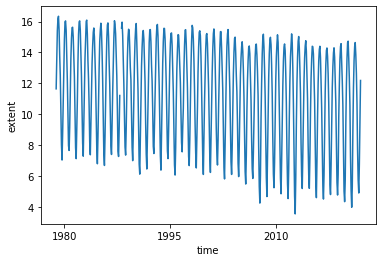

In [37]:
obs_sie.plot()

In [38]:
obs_sie_seas = obs_sie.rolling(time=3,min_periods=3, center=True).mean()

### Compute NSIDC NH Sea Ice Extent from Sea Ice Fraction (Skip)

In [32]:
# Observed SIE (SSMI nsidc-0051)
ds_obs = xr.open_dataset('/glade/p/cgd/oce/people/yeager/obs/seaice/NSIDC/nsidc-0051/nt_1979_01-2020_12.monthly.NH.nc',decode_times=False)
ds_obs['time'] = [cftime.DatetimeNoLeap(1979+year, 1+month, 15) for year in range(42) for month in range(12)]
obs_ifrac = ds_obs.ifrac
obs_ifrac = obs_ifrac.where(obs_ifrac>-1)   # eliminate shadow zone over Pole
region1 = (ds_obs.lat>=lat1) & (ds_obs.lat<=lat2)
areawgt1 = xr.where(region1, ds_obs.area.fillna(0),0)
obs_nhice = (obs_ifrac*areawgt1).sum(("nlon", "nlat")).load()

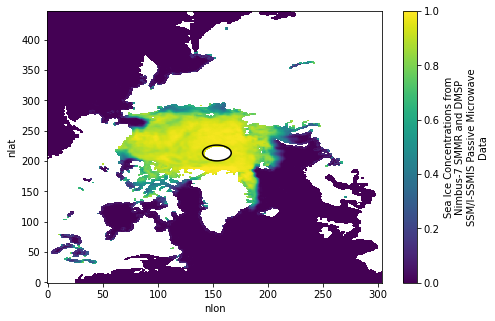

In [33]:
obs_ifrac.isel(time=117).plot(size=5);
xr.plot.contour(ds_obs.lat,levels=[87.],colors='k')

In [34]:
obs_nhice_seas = obs_nhice.rolling(time=3,min_periods=3, center=True).mean()

Slice NSIDC obs from 1988 onwards to avoid large missing data hole over NP

In [35]:
obs_nhice_seas = obs_nhice_seas.sel(time=slice("1988",None))

In [36]:
obs_nhice_seas.time

<xarray.DataArray 'time' (time: 396)>
array([cftime.DatetimeNoLeap(1988, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1988, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1988, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2020, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1988-01-15 00:00:00 ... 2020-12-15 00:00:00

# Plots

In [39]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_skill_byseas(mod_da,mod_time,obs_da,cy0,cy1,detrend=False):
    ens = mod_da.mean('M')
    seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}
    r_list = []
    p_list = []
    e_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_time_month = obs_da.time.dt.month
        obs_time_year = obs_da.time.dt.year
        obs_ts = obs_da.where(obs_time_month==ens_time_month).dropna('time')
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        obs_ts = obs_ts.assign_coords(time=("time",obs_ts.time.dt.year.data))
        obs_ts = obs_ts.assign_coords({"season":seasons[ens_time_month]})
        obs_ts = obs_ts - obs_ts.sel(time=slice(cy0,cy1)).mean('time')
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        e = xs.rmse(a,b,dim='time')/b.std('time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        e_list.append(e)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    rmse = xr.concat(e_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval,'rmse':rmse})

In [40]:
def leadtime_skill_byseas_withLE(mod_da,mod_time,obs_da,le_da,cy0,cy1,detrend=False):
    ens = mod_da.mean('M')
    seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}
    r_list = []
    p_list = []
    e_list = []
    r2_list = []
    p2_list = []
    e2_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_time_month = obs_da.time.dt.month
        obs_time_year = obs_da.time.dt.year
        le_time_month = le_da.time.dt.month
        le_time_year = le_da.time.dt.year
        obs_ts = obs_da.where(obs_time_month==ens_time_month).dropna('time')
        obs_ts = obs_ts.assign_coords(time=("time",obs_ts.time.dt.year.data))
        obs_ts = obs_ts.assign_coords({"season":seasons[ens_time_month]})
        obs_ts = obs_ts - obs_ts.sel(time=slice(cy0,cy1)).mean('time')
        le_ts = le_da.where(le_time_month==ens_time_month).dropna('time')
        le_ts = le_ts.assign_coords(time=("time",le_ts.time.dt.year.data))
        le_ts = le_ts.assign_coords({"season":seasons[ens_time_month]})
        le_ts = le_ts - le_ts.sel(time=slice(cy0,cy1)).mean('time')
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        c,d = xr.align(le_ts,b)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
                c = detrend_linear(c,'time')
        r = xs.pearson_r(a,b,dim='time')
        e = xs.rmse(a,b,dim='time')/b.std('time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r2 = xs.pearson_r(c,b,dim='time')
        e2 = xs.rmse(c,b,dim='time')/b.std('time')
        p2 = xs.pearson_r_eff_p_value(c,b,dim='time')
        r_list.append(r)
        e_list.append(e)
        p_list.append(p)
        r2_list.append(r2)
        e2_list.append(e2)
        p2_list.append(p2)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    rmse = xr.concat(e_list,ens.L)
    corr2 = xr.concat(r2_list,ens.L)
    pval2 = xr.concat(p2_list,ens.L)
    rmse2 = xr.concat(e2_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval,'rmse':rmse,'corr2':corr2,'pval2':pval2,'rmse2':rmse2})

### De-drift SMYLE data:

In [41]:
%%time
# Remove leadtime-dependent drift, using the following years for climatology:
climy0 = 1980
climy1 = 2015
smyle11_sie_dd,smyle11_sie_drift = stat.remove_drift(smyle11_sie,smyle11_time,climy0,climy1)
smyle02_sie_dd,smyle02_sie_drift = stat.remove_drift(smyle02_sie,smyle02_time,climy0,climy1)
smyle05_sie_dd,smyle05_sie_drift = stat.remove_drift(smyle05_sie,smyle05_time,climy0,climy1)
smyle08_sie_dd,smyle08_sie_drift = stat.remove_drift(smyle08_sie,smyle08_time,climy0,climy1)

CPU times: user 11.2 ms, sys: 22 µs, total: 11.2 ms
Wall time: 11.2 ms


### Compute Skill Scores:

In [42]:
%%time
# Correlation as a function of forecast lead month:
smyle11_skill = leadtime_skill_byseas_withLE(smyle11_sie_dd,smyle11_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_skill = leadtime_skill_byseas_withLE(smyle02_sie_dd,smyle02_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_skill = leadtime_skill_byseas_withLE(smyle05_sie_dd,smyle05_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_skill = leadtime_skill_byseas_withLE(smyle08_sie_dd,smyle08_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle11_skill_dt = leadtime_skill_byseas_withLE(smyle11_sie_dd,smyle11_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_skill_dt = leadtime_skill_byseas_withLE(smyle02_sie_dd,smyle02_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_skill_dt = leadtime_skill_byseas_withLE(smyle05_sie_dd,smyle05_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_skill_dt = leadtime_skill_byseas_withLE(smyle08_sie_dd,smyle08_time,obs_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encoun

CPU times: user 2.36 s, sys: 12.9 ms, total: 2.38 s
Wall time: 2.63 s


In [43]:
%%time
# Correlation as a function of forecast lead month:
smyle11_fskill = leadtime_skill_byseas_withLE(smyle11_sie_dd,smyle11_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_fskill = leadtime_skill_byseas_withLE(smyle02_sie_dd,smyle02_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_fskill = leadtime_skill_byseas_withLE(smyle05_sie_dd,smyle05_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_fskill = leadtime_skill_byseas_withLE(smyle08_sie_dd,smyle08_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle11_fskill_dt = leadtime_skill_byseas_withLE(smyle11_sie_dd,smyle11_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_fskill_dt = leadtime_skill_byseas_withLE(smyle02_sie_dd,smyle02_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_fskill_dt = leadtime_skill_byseas_withLE(smyle05_sie_dd,smyle05_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_fskill_dt = leadtime_skill_byseas_withLE(smyle08_sie_dd,smyle08_time,fosi_sie_seas,cesm2_sie_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encoun

CPU times: user 2.4 s, sys: 6.07 ms, total: 2.41 s
Wall time: 2.48 s


(0.2, 1.2)

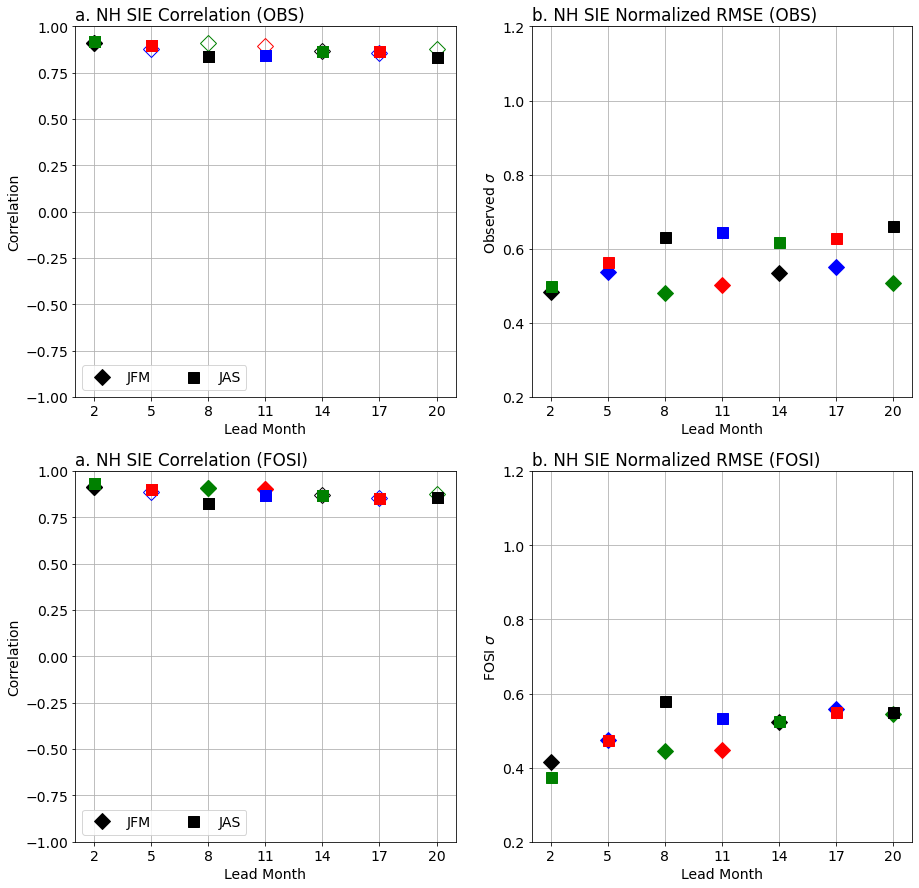

In [53]:
# plot correlation
fig = plt.figure(figsize=(15,15))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill.L-2
seasons = ['JFM','JAS']
markers = ['D','s']

ax = fig.add_subplot(2,2,1)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('a. NH SIE Correlation (OBS)',loc='left')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill.corr.where(smyle11_skill.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_skill.corr.where(smyle11_skill.season==i).where(smyle11_skill.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_skill.corr.where(smyle02_skill.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_skill.corr.where(smyle02_skill.season==i).where(smyle02_skill.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill.corr.where(smyle05_skill.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_skill.corr.where(smyle05_skill.season==i).where(smyle05_skill.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill.corr.where(smyle08_skill.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_skill.corr.where(smyle08_skill.season==i).where(smyle08_skill.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-1,1.])

ax = fig.add_subplot(2,2,2)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. NH SIE Normalized RMSE (OBS)',loc='left')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill.rmse.where(smyle11_skill.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_skill.rmse.where(smyle02_skill.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill.rmse.where(smyle05_skill.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill.rmse.where(smyle08_skill.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.2,1.2])

ax = fig.add_subplot(2,2,3)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('a. NH SIE Correlation (FOSI)',loc='left')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill.corr.where(smyle11_fskill.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_fskill.corr.where(smyle11_fskill.season==i).where(smyle11_fskill.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_fskill.corr.where(smyle02_fskill.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_fskill.corr.where(smyle02_fskill.season==i).where(smyle02_fskill.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill.corr.where(smyle05_fskill.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_fskill.corr.where(smyle05_fskill.season==i).where(smyle05_fskill.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill.corr.where(smyle08_fskill.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_fskill.corr.where(smyle08_fskill.season==i).where(smyle08_fskill.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-1,1])

ax = fig.add_subplot(2,2,4)
ax.set_ylabel(r'FOSI $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. NH SIE Normalized RMSE (FOSI)',loc='left')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill.rmse.where(smyle11_fskill.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_fskill.rmse.where(smyle02_fskill.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill.rmse.where(smyle05_fskill.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill.rmse.where(smyle08_fskill.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.2,1.2])

(0.2, 1.2)

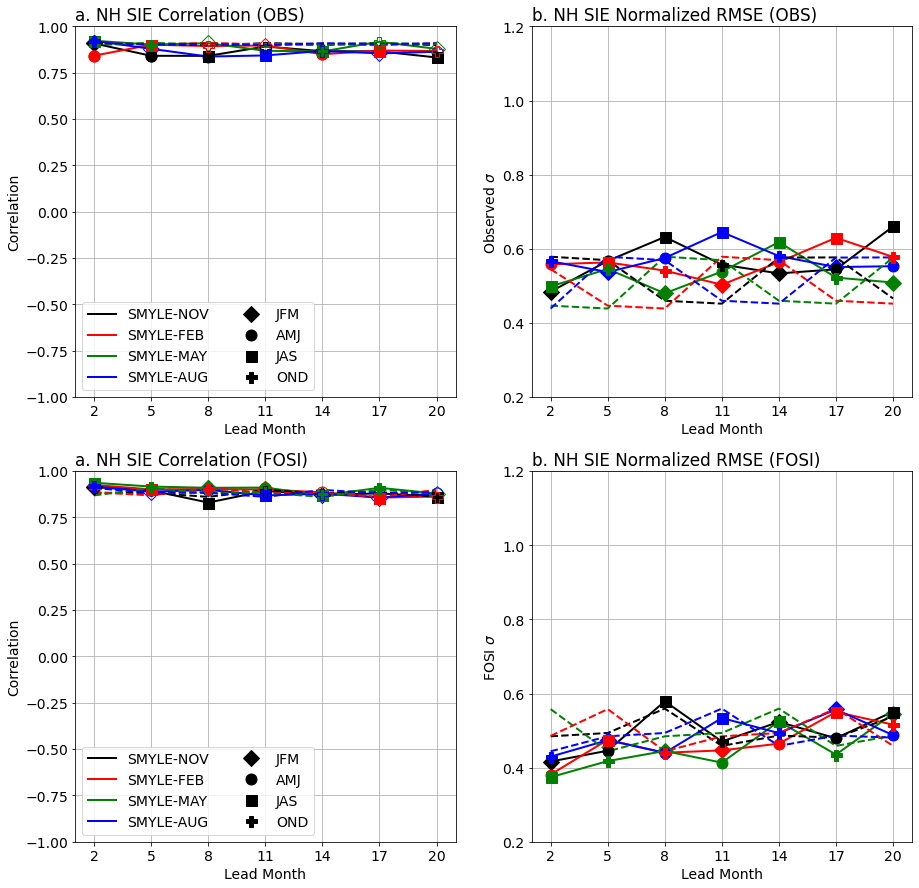

In [54]:
# plot correlation
fig = plt.figure(figsize=(15,15))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill.L-2
seasons = ['JFM','AMJ','JAS','OND']
markers = ['D','o','s','P']
#seasons = ['JFM','JAS']
#markers = ['D','s']

ax = fig.add_subplot(2,2,1)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('a. NH SIE Correlation (OBS)',loc='left')
ax.plot(leadmon,smyle11_skill.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_skill.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_skill.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_skill.corr,color='b',linewidth=2,label='SMYLE-AUG')
ax.plot(leadmon,smyle11_skill.corr2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_skill.corr2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_skill.corr2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_skill.corr2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill.corr.where(smyle11_skill.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_skill.corr.where(smyle11_skill.season==i).where(smyle11_skill.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_skill.corr.where(smyle02_skill.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_skill.corr.where(smyle02_skill.season==i).where(smyle02_skill.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill.corr.where(smyle05_skill.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_skill.corr.where(smyle05_skill.season==i).where(smyle05_skill.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill.corr.where(smyle08_skill.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_skill.corr.where(smyle08_skill.season==i).where(smyle08_skill.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-1,1.])

ax = fig.add_subplot(2,2,2)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. NH SIE Normalized RMSE (OBS)',loc='left')
ax.plot(leadmon,smyle11_skill.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_skill.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_skill.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_skill.rmse,color='b',linewidth=2)
ax.plot(leadmon,smyle11_skill.rmse2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_skill.rmse2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_skill.rmse2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_skill.rmse2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill.rmse.where(smyle11_skill.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_skill.rmse.where(smyle02_skill.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill.rmse.where(smyle05_skill.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill.rmse.where(smyle08_skill.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.2,1.2])

ax = fig.add_subplot(2,2,3)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('a. NH SIE Correlation (FOSI)',loc='left')
ax.plot(leadmon,smyle11_fskill.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_fskill.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_fskill.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_fskill.corr,color='b',linewidth=2,label='SMYLE-AUG')
ax.plot(leadmon,smyle11_fskill.corr2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_fskill.corr2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_fskill.corr2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_fskill.corr2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill.corr.where(smyle11_fskill.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_fskill.corr.where(smyle11_fskill.season==i).where(smyle11_fskill.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_fskill.corr.where(smyle02_fskill.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_fskill.corr.where(smyle02_fskill.season==i).where(smyle02_fskill.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill.corr.where(smyle05_fskill.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_fskill.corr.where(smyle05_fskill.season==i).where(smyle05_fskill.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill.corr.where(smyle08_fskill.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_fskill.corr.where(smyle08_fskill.season==i).where(smyle08_fskill.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-1,1])

ax = fig.add_subplot(2,2,4)
ax.set_ylabel(r'FOSI $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. NH SIE Normalized RMSE (FOSI)',loc='left')
ax.plot(leadmon,smyle11_fskill.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_fskill.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_fskill.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_fskill.rmse,color='b',linewidth=2)
ax.plot(leadmon,smyle11_fskill.rmse2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_fskill.rmse2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_fskill.rmse2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_fskill.rmse2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill.rmse.where(smyle11_fskill.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_fskill.rmse.where(smyle02_fskill.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill.rmse.where(smyle05_fskill.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill.rmse.where(smyle08_fskill.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.2,1.2])

(0.4, 1.6)

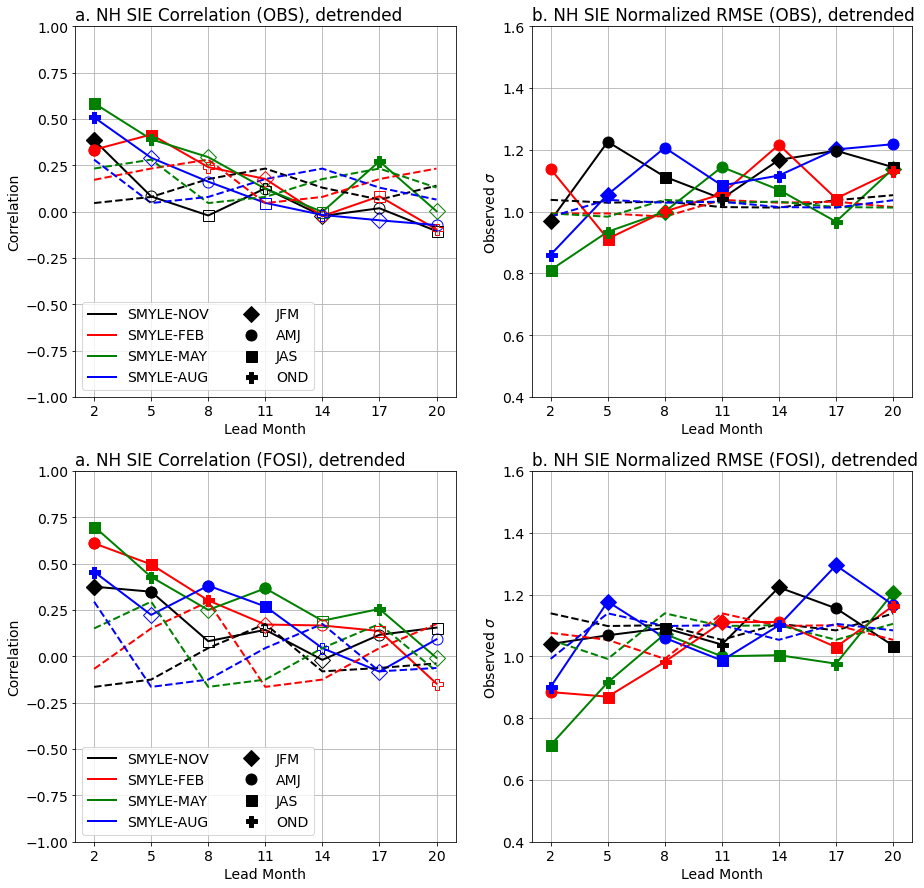

In [55]:
# plot correlation
fig = plt.figure(figsize=(15,15))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill_dt.L-2
seasons = ['JFM','AMJ','JAS','OND']
markers = ['D','o','s','P']
#seasons = ['JFM','JAS']
#markers = ['D','s']

ax = fig.add_subplot(2,2,1)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('a. NH SIE Correlation (OBS), detrended',loc='left')
ax.plot(leadmon,smyle11_skill_dt.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_skill_dt.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_skill_dt.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_skill_dt.corr,color='b',linewidth=2,label='SMYLE-AUG')
ax.plot(leadmon,smyle11_skill_dt.corr2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_skill_dt.corr2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_skill_dt.corr2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_skill_dt.corr2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill_dt.corr.where(smyle11_skill_dt.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_skill_dt.corr.where(smyle11_skill_dt.season==i).where(smyle11_skill_dt.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_skill_dt.corr.where(smyle02_skill_dt.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_skill_dt.corr.where(smyle02_skill_dt.season==i).where(smyle02_skill_dt.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill_dt.corr.where(smyle05_skill_dt.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_skill_dt.corr.where(smyle05_skill_dt.season==i).where(smyle05_skill_dt.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill_dt.corr.where(smyle08_skill_dt.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_skill_dt.corr.where(smyle08_skill_dt.season==i).where(smyle08_skill_dt.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-1,1])

ax = fig.add_subplot(2,2,2)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. NH SIE Normalized RMSE (OBS), detrended',loc='left')
ax.plot(leadmon,smyle11_skill_dt.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_skill_dt.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_skill_dt.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_skill_dt.rmse,color='b',linewidth=2)
ax.plot(leadmon,smyle11_skill_dt.rmse2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_skill_dt.rmse2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_skill_dt.rmse2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_skill_dt.rmse2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill_dt.rmse.where(smyle11_skill_dt.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_skill_dt.rmse.where(smyle02_skill_dt.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill_dt.rmse.where(smyle05_skill_dt.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill_dt.rmse.where(smyle08_skill_dt.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.4,1.6])

ax = fig.add_subplot(2,2,3)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('a. NH SIE Correlation (FOSI), detrended',loc='left')
ax.plot(leadmon,smyle11_fskill_dt.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_fskill_dt.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_fskill_dt.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_fskill_dt.corr,color='b',linewidth=2,label='SMYLE-AUG')
ax.plot(leadmon,smyle11_fskill_dt.corr2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_fskill_dt.corr2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_fskill_dt.corr2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_fskill_dt.corr2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill_dt.corr.where(smyle11_fskill_dt.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_fskill_dt.corr.where(smyle11_fskill_dt.season==i).where(smyle11_fskill_dt.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_fskill_dt.corr.where(smyle02_fskill_dt.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_fskill_dt.corr.where(smyle02_fskill_dt.season==i).where(smyle02_fskill_dt.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill_dt.corr.where(smyle05_fskill_dt.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_fskill_dt.corr.where(smyle05_fskill_dt.season==i).where(smyle05_fskill_dt.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill_dt.corr.where(smyle08_fskill_dt.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_fskill_dt.corr.where(smyle08_fskill_dt.season==i).where(smyle08_fskill_dt.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-1,1])

ax = fig.add_subplot(2,2,4)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. NH SIE Normalized RMSE (FOSI), detrended',loc='left')
ax.plot(leadmon,smyle11_fskill_dt.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_fskill_dt.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_fskill_dt.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_fskill_dt.rmse,color='b',linewidth=2)
ax.plot(leadmon,smyle11_fskill_dt.rmse2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_fskill_dt.rmse2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_fskill_dt.rmse2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_fskill_dt.rmse2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill_dt.rmse.where(smyle11_fskill_dt.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_fskill_dt.rmse.where(smyle02_fskill_dt.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill_dt.rmse.where(smyle05_fskill_dt.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill_dt.rmse.where(smyle08_fskill_dt.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.4,1.6])

### Skill Score Table (detrended)

In [44]:
skill = xr.concat([smyle11_skill,smyle02_skill,smyle05_skill,smyle08_skill],['NOV','FEB','MAY','AUG'])
skill['pval2'] = skill.pval2.fillna(-1)
fskill = xr.concat([smyle11_fskill,smyle02_fskill,smyle05_fskill,smyle08_fskill],['NOV','FEB','MAY','AUG'])
fskill['pval2'] = fskill.pval2.fillna(-1)

In [45]:
nlead = skill.sizes['L']
print("SMYLE SKILL FOR JFM (RAW)")
for i in range(nlead):
    tmp = skill.isel(L=i)
    tmp = tmp.where(tmp.season=='JFM').dropna('concat_dim')
    ftmp = fskill.isel(L=i)
    ftmp = ftmp.where(ftmp.season=='JFM').dropna('concat_dim')
    outstr = "Lead month: {0}, Start: {1}, Corr: {2:4.3f}, Pval: {3:4.3f}, Rmse: {4:4.3f}, FOSI-Corr: {5:4.3f}, FOSI-Pval: {6:4.3f}, FOSI-Rmse: {7:4.3f}"
    print(outstr.format(tmp.L.data-2,tmp.concat_dim.data[0],tmp.corr.data[0],tmp.pval.data[0],tmp.rmse.data[0],ftmp.corr.data[0],ftmp.pval.data[0],ftmp.rmse.data[0]))
print("SMYLE SKILL FOR JAS (RAW)")
for i in range(nlead):
    tmp = skill.isel(L=i)
    tmp = tmp.where(tmp.season=='JAS').dropna('concat_dim')
    ftmp = fskill.isel(L=i)
    ftmp = ftmp.where(ftmp.season=='JAS').dropna('concat_dim')
    outstr = "Lead month: {0}, Start: {1}, Corr: {2:4.3f}, Pval: {3:4.3f}, Rmse: {4:4.3f}, FOSI-Corr: {5:4.3f}, FOSI-Pval: {6:4.3f}, FOSI-Rmse: {7:4.3f}"
    print(outstr.format(tmp.L.data-2,tmp.concat_dim.data[0],tmp.corr.data[0],tmp.pval.data[0],tmp.rmse.data[0],ftmp.corr.data[0],ftmp.pval.data[0],ftmp.rmse.data[0]))

SMYLE SKILL FOR JFM (RAW)
Lead month: 2, Start: NOV, Corr: 0.908, Pval: 0.092, Rmse: 0.484, FOSI-Corr: 0.914, FOSI-Pval: 0.086, FOSI-Rmse: 0.417
Lead month: 5, Start: AUG, Corr: 0.879, Pval: 0.317, Rmse: 0.537, FOSI-Corr: 0.889, FOSI-Pval: 0.111, FOSI-Rmse: 0.474
Lead month: 8, Start: MAY, Corr: 0.909, Pval: 0.273, Rmse: 0.480, FOSI-Corr: 0.910, FOSI-Pval: 0.090, FOSI-Rmse: 0.445
Lead month: 11, Start: FEB, Corr: 0.897, Pval: 0.292, Rmse: 0.503, FOSI-Corr: 0.901, FOSI-Pval: 0.099, FOSI-Rmse: 0.447
Lead month: 14, Start: NOV, Corr: 0.866, Pval: 0.333, Rmse: 0.534, FOSI-Corr: 0.872, FOSI-Pval: 0.128, FOSI-Rmse: 0.523
Lead month: 17, Start: AUG, Corr: 0.855, Pval: 0.348, Rmse: 0.551, FOSI-Corr: 0.858, FOSI-Pval: 0.142, FOSI-Rmse: 0.557
Lead month: 20, Start: MAY, Corr: 0.879, Pval: 0.317, Rmse: 0.509, FOSI-Corr: 0.879, FOSI-Pval: 0.121, FOSI-Rmse: 0.546
SMYLE SKILL FOR JAS (RAW)
Lead month: 2, Start: MAY, Corr: 0.923, Pval: 0.003, Rmse: 0.499, FOSI-Corr: 0.937, FOSI-Pval: 0.000, FOSI-Rmse

In [47]:
skill_dt = xr.concat([smyle11_skill_dt,smyle02_skill_dt,smyle05_skill_dt,smyle08_skill_dt],['NOV','FEB','MAY','AUG'])
fskill_dt = xr.concat([smyle11_fskill_dt,smyle02_fskill_dt,smyle05_fskill_dt,smyle08_fskill_dt],['NOV','FEB','MAY','AUG'])

In [48]:
nlead = skill_dt.sizes['L']
print("SMYLE SKILL FOR JFM (DETRENDED)")
for i in range(nlead):
    tmp = skill_dt.isel(L=i)
    tmp = tmp.where(tmp.season=='JFM').dropna('concat_dim')
    ftmp = fskill_dt.isel(L=i)
    ftmp = ftmp.where(ftmp.season=='JFM').dropna('concat_dim')
    outstr = "Lead month: {0}, Start: {1}, Corr: {2:4.3f}, Pval: {3:4.3f}, Rmse: {4:4.3f}, FOSI-Corr: {5:4.3f}, FOSI-Pval: {6:4.3f}, FOSI-Rmse: {7:4.3f}"
    print(outstr.format(tmp.L.data-2,tmp.concat_dim.data[0],tmp.corr.data[0],tmp.pval.data[0],tmp.rmse.data[0],ftmp.corr.data[0],ftmp.pval.data[0],ftmp.rmse.data[0]))
print("SMYLE SKILL FOR JAS (DETRENDED)")
for i in range(nlead):
    tmp = skill_dt.isel(L=i)
    tmp = tmp.where(tmp.season=='JAS').dropna('concat_dim')
    ftmp = fskill_dt.isel(L=i)
    ftmp = ftmp.where(ftmp.season=='JAS').dropna('concat_dim')
    outstr = "Lead month: {0}, Start: {1}, Corr: {2:4.3f}, Pval: {3:4.3f}, Rmse: {4:4.3f}, FOSI-Corr: {5:4.3f}, FOSI-Pval: {6:4.3f}, FOSI-Rmse: {7:4.3f}"
    print(outstr.format(tmp.L.data-2,tmp.concat_dim.data[0],tmp.corr.data[0],tmp.pval.data[0],tmp.rmse.data[0],ftmp.corr.data[0],ftmp.pval.data[0],ftmp.rmse.data[0]))

SMYLE SKILL FOR JFM (DETRENDED)
Lead month: 2, Start: NOV, Corr: 0.386, Pval: 0.032, Rmse: 0.972, FOSI-Corr: 0.377, FOSI-Pval: 0.018, FOSI-Rmse: 1.040
Lead month: 5, Start: AUG, Corr: 0.291, Pval: 0.141, Rmse: 1.056, FOSI-Corr: 0.224, FOSI-Pval: 0.202, FOSI-Rmse: 1.177
Lead month: 8, Start: MAY, Corr: 0.295, Pval: 0.121, Rmse: 1.000, FOSI-Corr: 0.251, FOSI-Pval: 0.140, FOSI-Rmse: 1.073
Lead month: 11, Start: FEB, Corr: 0.177, Pval: 0.350, Rmse: 1.057, FOSI-Corr: 0.172, FOSI-Pval: 0.307, FOSI-Rmse: 1.111
Lead month: 14, Start: NOV, Corr: -0.023, Pval: 0.900, Rmse: 1.168, FOSI-Corr: -0.018, FOSI-Pval: 0.911, FOSI-Rmse: 1.224
Lead month: 17, Start: AUG, Corr: -0.046, Pval: 0.819, Rmse: 1.202, FOSI-Corr: -0.082, FOSI-Pval: 0.642, FOSI-Rmse: 1.295
Lead month: 20, Start: MAY, Corr: 0.003, Pval: 0.989, Rmse: 1.139, FOSI-Corr: -0.007, FOSI-Pval: 0.965, FOSI-Rmse: 1.205
SMYLE SKILL FOR JAS (DETRENDED)
Lead month: 2, Start: MAY, Corr: 0.585, Pval: 0.000, Rmse: 0.811, FOSI-Corr: 0.701, FOSI-Pval:

### Time Series Plots

In [49]:
## First, compute JFM/JAS anomaly time series from OBS & FOSI & CESM2-LE:
obsmon = obs_sie_seas.time.dt.month
obsjfm = obs_sie_seas.where(obsmon==2).dropna('time')
obsjfm = obsjfm.assign_coords(time=("time",obsjfm.time.dt.year.data))
obsjfm = obsjfm - obsjfm.sel(time=slice(climy0,climy1)).mean('time')
obsjas = obs_sie_seas.where(obsmon==8).dropna('time')
obsjas = obsjas.assign_coords(time=("time",obsjas.time.dt.year.data))
obsjas = obsjas - obsjas.sel(time=slice(climy0,climy1)).mean('time')

fosimon = fosi_sie_seas.time.dt.month
fosijfm = fosi_sie_seas.where(fosimon==2).dropna('time')
fosijfm = fosijfm.assign_coords(time=("time",fosijfm.time.dt.year.data))
fosijfm = fosijfm - fosijfm.sel(time=slice(climy0,climy1)).mean('time')
fosijas = fosi_sie_seas.where(fosimon==8).dropna('time')
fosijas = fosijas.assign_coords(time=("time",fosijas.time.dt.year.data))
fosijas = fosijas - fosijas.sel(time=slice(climy0,climy1)).mean('time')

cesm2mon = cesm2_sie_seas.time.dt.month
cesm2jfm = cesm2_sie_seas.where(cesm2mon==2).dropna('time')
cesm2jfm = cesm2jfm.assign_coords(time=("time",cesm2jfm.time.dt.year.data))
cesm2jfm = cesm2jfm - cesm2jfm.sel(time=slice(climy0,climy1)).mean('time')
cesm2jas = cesm2_sie_seas.where(cesm2mon==8).dropna('time')
cesm2jas = cesm2jas.assign_coords(time=("time",cesm2jas.time.dt.year.data))
cesm2jas = cesm2jas - cesm2jas.sel(time=slice(climy0,climy1)).mean('time')

In [73]:
smyle11_skill_dt.corr.data

array([ 0.38628634,  0.08242616, -0.02033437,  0.12615162, -0.02303607,
        0.01878278, -0.10479892])

In [74]:
smyle11_skill_dt.L

<xarray.DataArray 'L' (L: 7)>
array([ 4,  7, 10, 13, 16, 19, 22])
Coordinates:
  * L        (L) int64 4 7 10 13 16 19 22
    units    <U4 'km^2'
    season   (L) <U3 'JFM' 'AMJ' 'JAS' 'OND' 'JFM' 'AMJ' 'JAS'

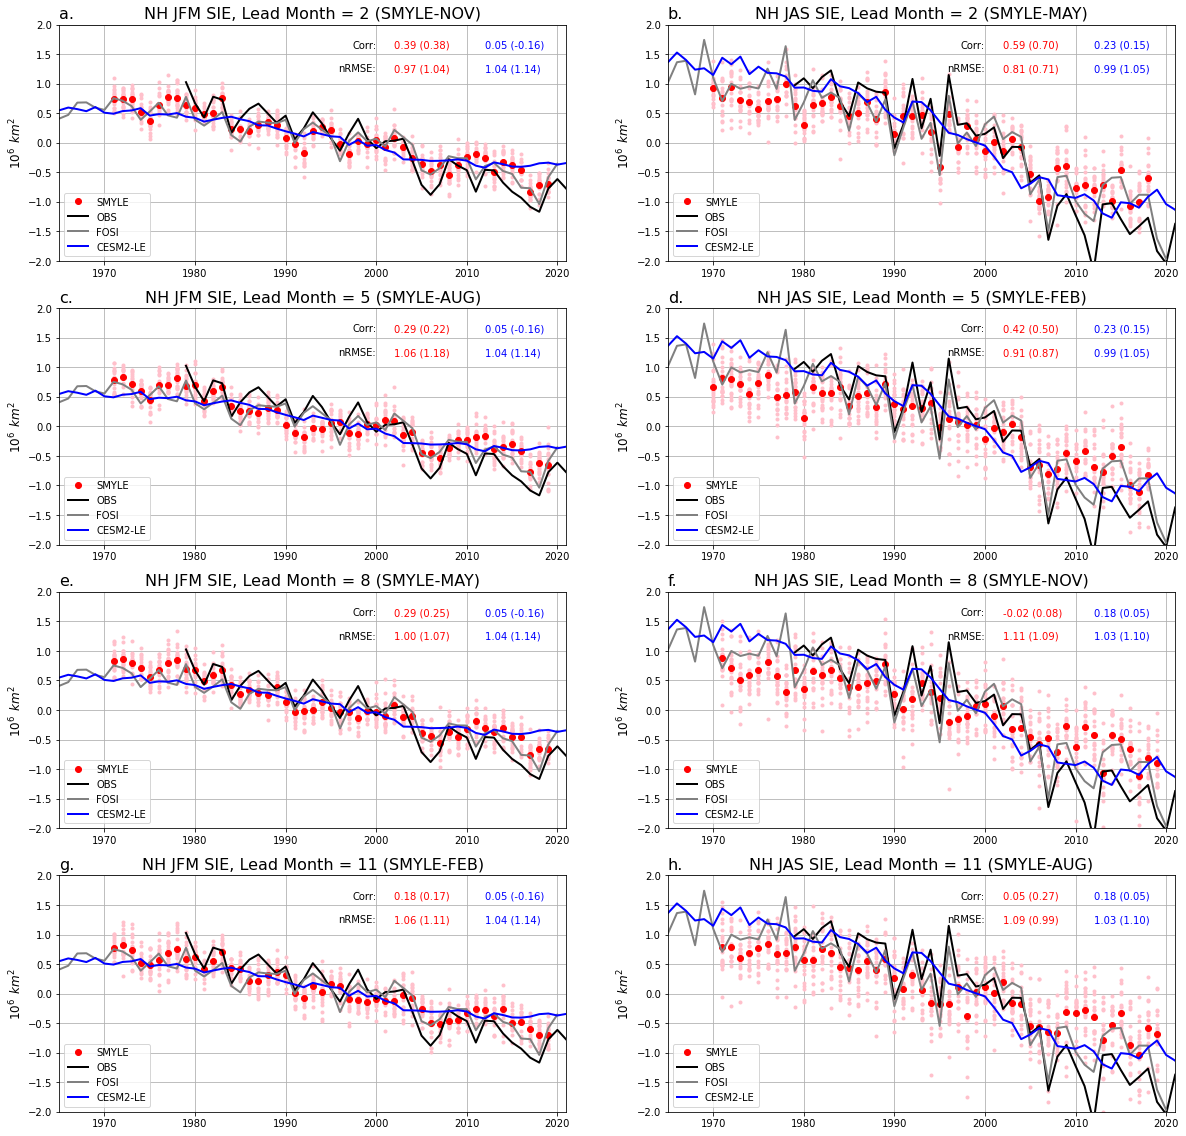

In [63]:
leads = [4,7,10,13]
nlead = np.size(leads)
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2
seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = 1965
xmax = 2021
ymin = -2
ymax = 2

lead = leads[0]
ax = fig.add_subplot(nrow,ncol,1)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('a.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr.data,smyle11_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr2.data,smyle11_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse.data,smyle11_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse2.data,smyle11_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,2)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('b.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr.data,smyle05_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr2.data,smyle05_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse.data,smyle05_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse2.data,smyle05_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[1]
ax = fig.add_subplot(nrow,ncol,3)
smylemon = smyle08_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle08_time.sel(L=lead).dt.year
smyledata = smyle08_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-AUG)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('c.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).corr.data,smyle08_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).corr2.data,smyle08_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).rmse.data,smyle08_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).rmse2.data,smyle08_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,4)
smylemon = smyle02_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle02_time.sel(L=lead).dt.year
smyledata = smyle02_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-FEB)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('d.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).corr.data,smyle02_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).corr2.data,smyle02_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).rmse.data,smyle02_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).rmse2.data,smyle02_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[2]
ax = fig.add_subplot(nrow,ncol,5)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('e.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr.data,smyle05_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr2.data,smyle05_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse.data,smyle05_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse2.data,smyle05_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,6)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('f.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr.data,smyle11_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr2.data,smyle11_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse.data,smyle11_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse2.data,smyle11_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[3]
ax = fig.add_subplot(nrow,ncol,7)
smylemon = smyle02_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle02_time.sel(L=lead).dt.year
smyledata = smyle02_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='OBS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-FEB)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('g.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).corr.data,smyle02_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).corr2.data,smyle02_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).rmse.data,smyle02_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).rmse2.data,smyle02_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,8)
smylemon = smyle08_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle08_time.sel(L=lead).dt.year
smyledata = smyle08_sie_dd.sel(L=lead)
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='OBS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIE, Lead Month = {} (SMYLE-AUG)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('h.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^6 \:\: km^{2}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,1.6,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).corr.data,smyle08_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,1.6,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).corr2.data,smyle08_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,1.2,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).rmse.data,smyle08_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,1.2,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).rmse2.data,smyle08_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

plt.savefig('NH_SIE_skill.png')